In [15]:
import numpy as np

from nanopyx.core.transform.image_shift_rotate import *
from skimage.draw import rectangle

from matplotlib import pyplot as plt

angle = np.pi
cx = 300.0
cy = 100.0

image_GT = np.zeros((256, 512), dtype=np.float32) 
rr, cc = rectangle((int(cy-20), int(cx-40)), extent=(40,-40), shape=image_GT.shape)
image_GT[rr,cc] = 1

image = np.zeros((256, 512), dtype=np.float32) 
rr, cc = rectangle((int(cy-20), int(cx+40)), extent=(40,40), shape=image.shape)
image[rr,cc] = 1


In [16]:
%%prun -s cumulative -q -l 100 -T prun_Rotation.profile
# Profile the run

imageNNRotation = nearest_neighbor_rotate_shift(image, angle, cx, cy)
imageBLRotation = bilinear_rotate_shift(image, angle, cx, cy)
imageBCRotation = bicubic_rotate_shift(image, angle, cx, cy)
imageCRRotation = catmull_rom_rotate_shift(image, angle, cx, cy)
imageLRotation = lanczos_rotate_shift(image, angle, cx, cy)
#imageScipyRotation = scipy_rotate_shift(image, angle, cx, cy)
imageSkiRotation = skimage_rotate_shift(image, angle, cx, cy)
imageCVRotation = cv2_rotate_shift(image, angle, cx, cy)


rotated_images = {
    "nearest-neighbor-rotation": imageNNRotation,
    "bilinear-rotation": imageBLRotation,
    "bilinear-rotation": imageBLRotation,
    "bicubic-rotation": imageBCRotation,
    "catmull-rom-rotation": imageCRRotation,
    "lanczos-rotation": imageLRotation,
    #"scipy-rotation": imageScipyRotation,
    "skimage-rotation": imageSkiRotation,
    "cv2-rotation": imageCVRotation
}

nearest_neighbor_rotate_shift took 0.517130 mseconds
bilinear_rotate_shift took 0.811100 mseconds
bicubic_rotate_shift took 0.565052 mseconds
catmull_rom_rotate_shift took 0.887632 mseconds
lanczos_rotate_shift took 7.258892 mseconds
skimage_rotate_shift took 0.960827 mseconds
cv2_rotate_shift took 0.270128 mseconds
 
*** Profile printout saved to text file 'prun_Rotation.profile'.


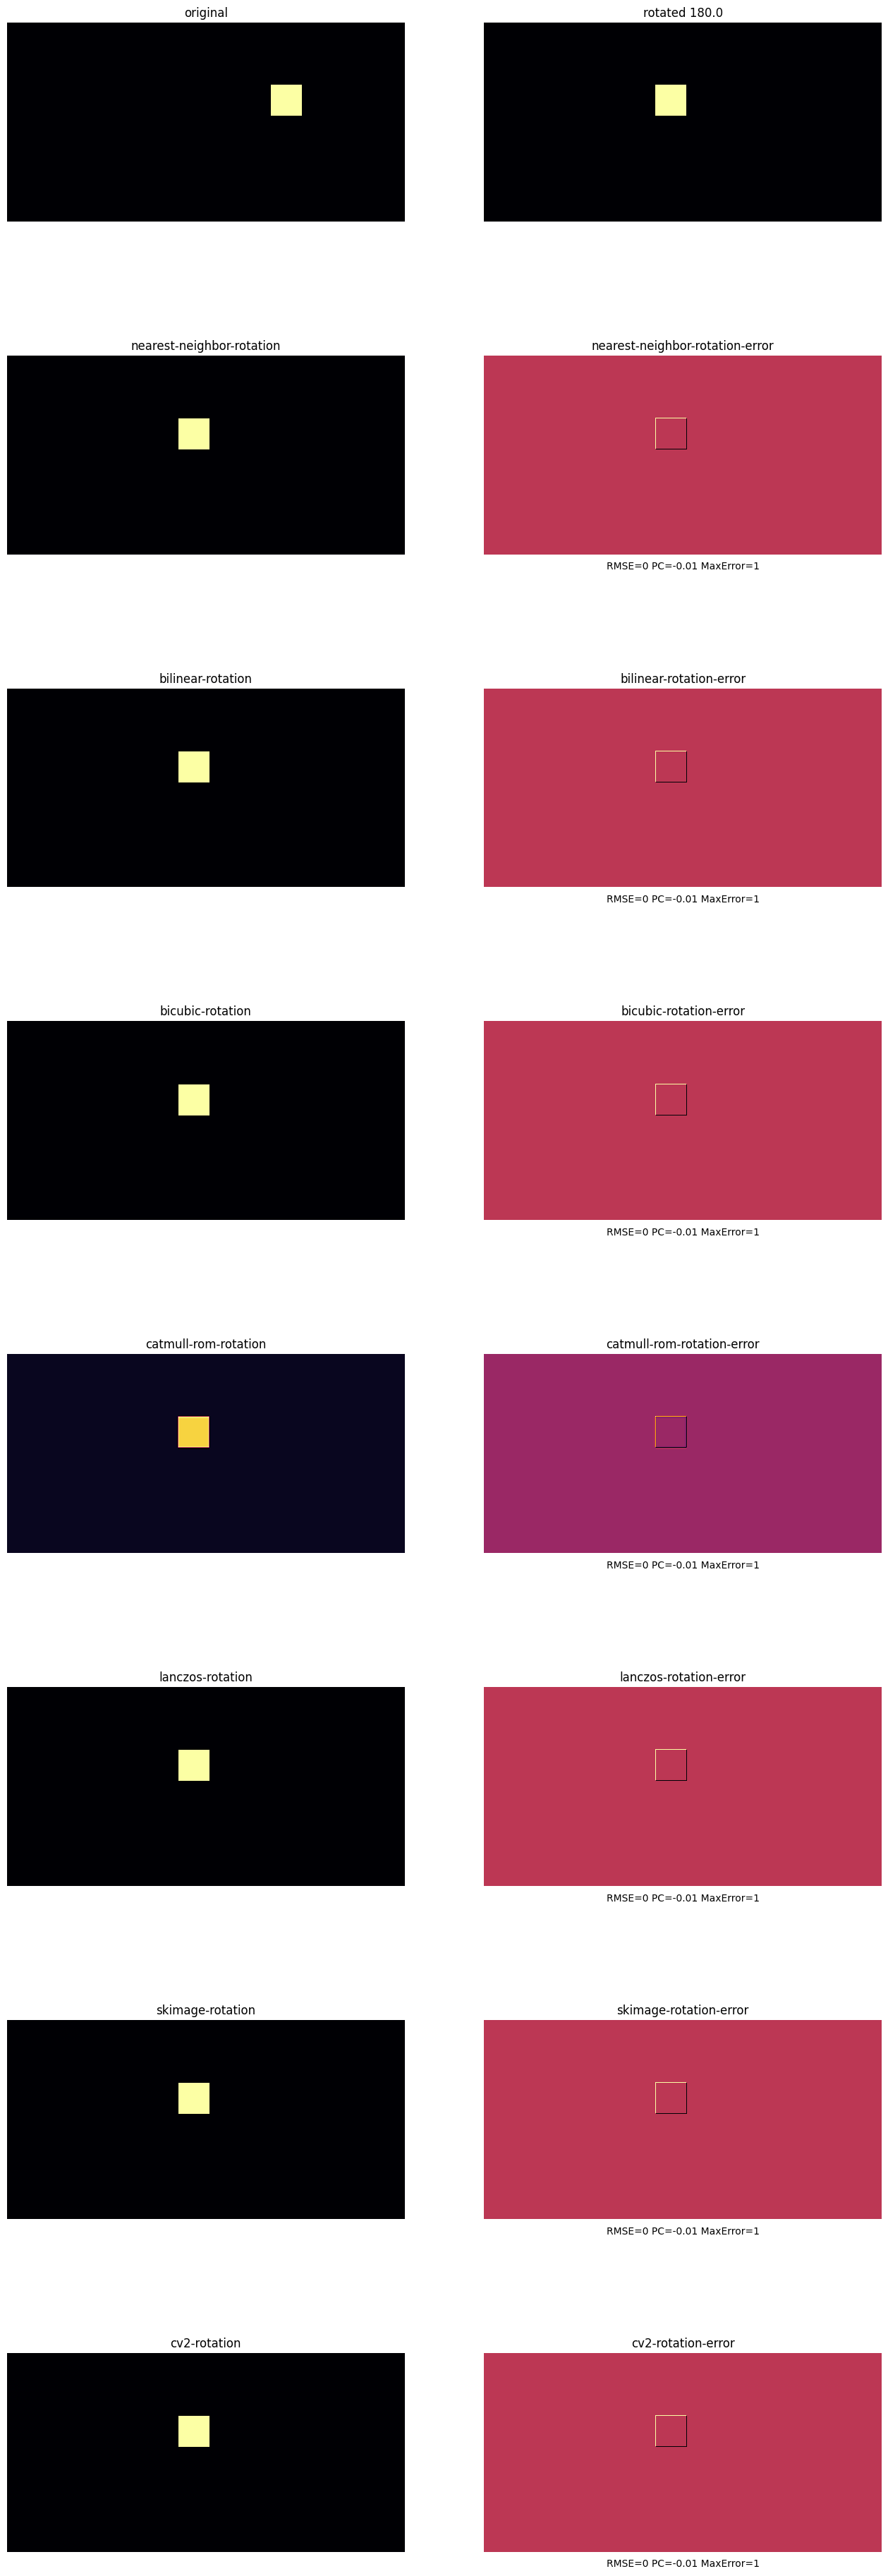

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from nanopyx.core.analysis.pearson_correlation import pearson_correlation
import numpy as np

plt.close('all')
# Create a figure with 3 subplots arranged in a row
fig, axs = plt.subplots(len(rotated_images)+1, 2, figsize=(16, 3*16))
sns.heatmap(image, ax=axs[0,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(image_GT, ax=axs[0,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[0,0].set_title("original")
axs[0,1].set_title(f"rotated {np.rad2deg(angle):.1f}")

for i, id in enumerate(rotated_images):
    rotated_image = rotated_images[id]
    error = image_GT-rotated_image
    rmse = round((error**2).mean()**0.5)
    pc = pearson_correlation(image, rotated_image)
    sns.heatmap(rotated_image, ax=axs[i+1,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
    sns.heatmap(error, ax=axs[i+1,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
    axs[i+1,0].set_title(f"{id}")
    axs[i+1,1].set_title(f"{id}-error")
    axs[i+1,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

# Show the figure
plt.show()
